In [1]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Uncomment to install ydata-synthetic lib
#!pip install ydata-synthetic

# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [1]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [2]:
#Specific to TimeGANs
seq_len=24
n_seq = 22
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = [batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim]

## The data

In [23]:
from sklearn.preprocessing import MinMaxScaler
# Load Google Data
x = np.loadtxt('test5years.csv', delimiter = ",",skiprows = 1)
# Flip the data to make chronological data
x = x[::-1]
x = (x[1:,:] - x[:-1,:])/x[:-1,:]

# a = x[:,:15]
# a = (a[1:,:] - a[:-1,:])/a[:-1,:]
# x = np.append(a,x[1:,15:],axis=1)
# Min-Max Normalizer
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
seq_length = 24

# Build dataset
dataX = []

# Cut data by sequence length
for i in range(0, len(x) - seq_length):
    _x = x[i:i + seq_length]
    dataX.append(_x)
    
# Mix Data (to make it similar to i.i.d)
idx = np.random.permutation(len(dataX))

outputX = []
for i in range(len(dataX)):
    outputX.append(dataX[idx[i]])
    
stock_data = outputX #processed_stock(seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

1383 (24, 22)


## Training the TimeGAN synthetizer

In [24]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=5000)
    synth.save('synthesizer_stock.pkl')

### The generated synthetic stock data

In [26]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|███████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.96it/s]

(1408, 24, 22)


In [27]:
synth_data

array([[[0.48075914, 0.4809239 , 0.42589134, ..., 0.39236385,
         0.5352863 , 0.26708204],
        [0.45596173, 0.4469981 , 0.41514394, ..., 0.41600674,
         0.52339655, 0.25230235],
        [0.5115394 , 0.51026154, 0.48597988, ..., 0.3215158 ,
         0.54259574, 0.3055938 ],
        ...,
        [0.56887704, 0.5914965 , 0.51633555, ..., 0.34520033,
         0.57337296, 0.45780218],
        [0.52652633, 0.5450589 , 0.4809595 , ..., 0.42855483,
         0.56072587, 0.53017706],
        [0.55206573, 0.5748944 , 0.4875186 , ..., 0.2913226 ,
         0.5578629 , 0.5060436 ]],

       [[0.5317772 , 0.5442056 , 0.47597072, ..., 0.4448119 ,
         0.5562699 , 0.39092565],
        [0.47921693, 0.48705012, 0.45259818, ..., 0.52769285,
         0.53717244, 0.36034057],
        [0.56022376, 0.57972884, 0.50625086, ..., 0.5279774 ,
         0.5594866 , 0.51163757],
        ...,
        [0.53158706, 0.5484673 , 0.4399855 , ..., 0.41508746,
         0.56069505, 0.5832331 ],
        [0.6

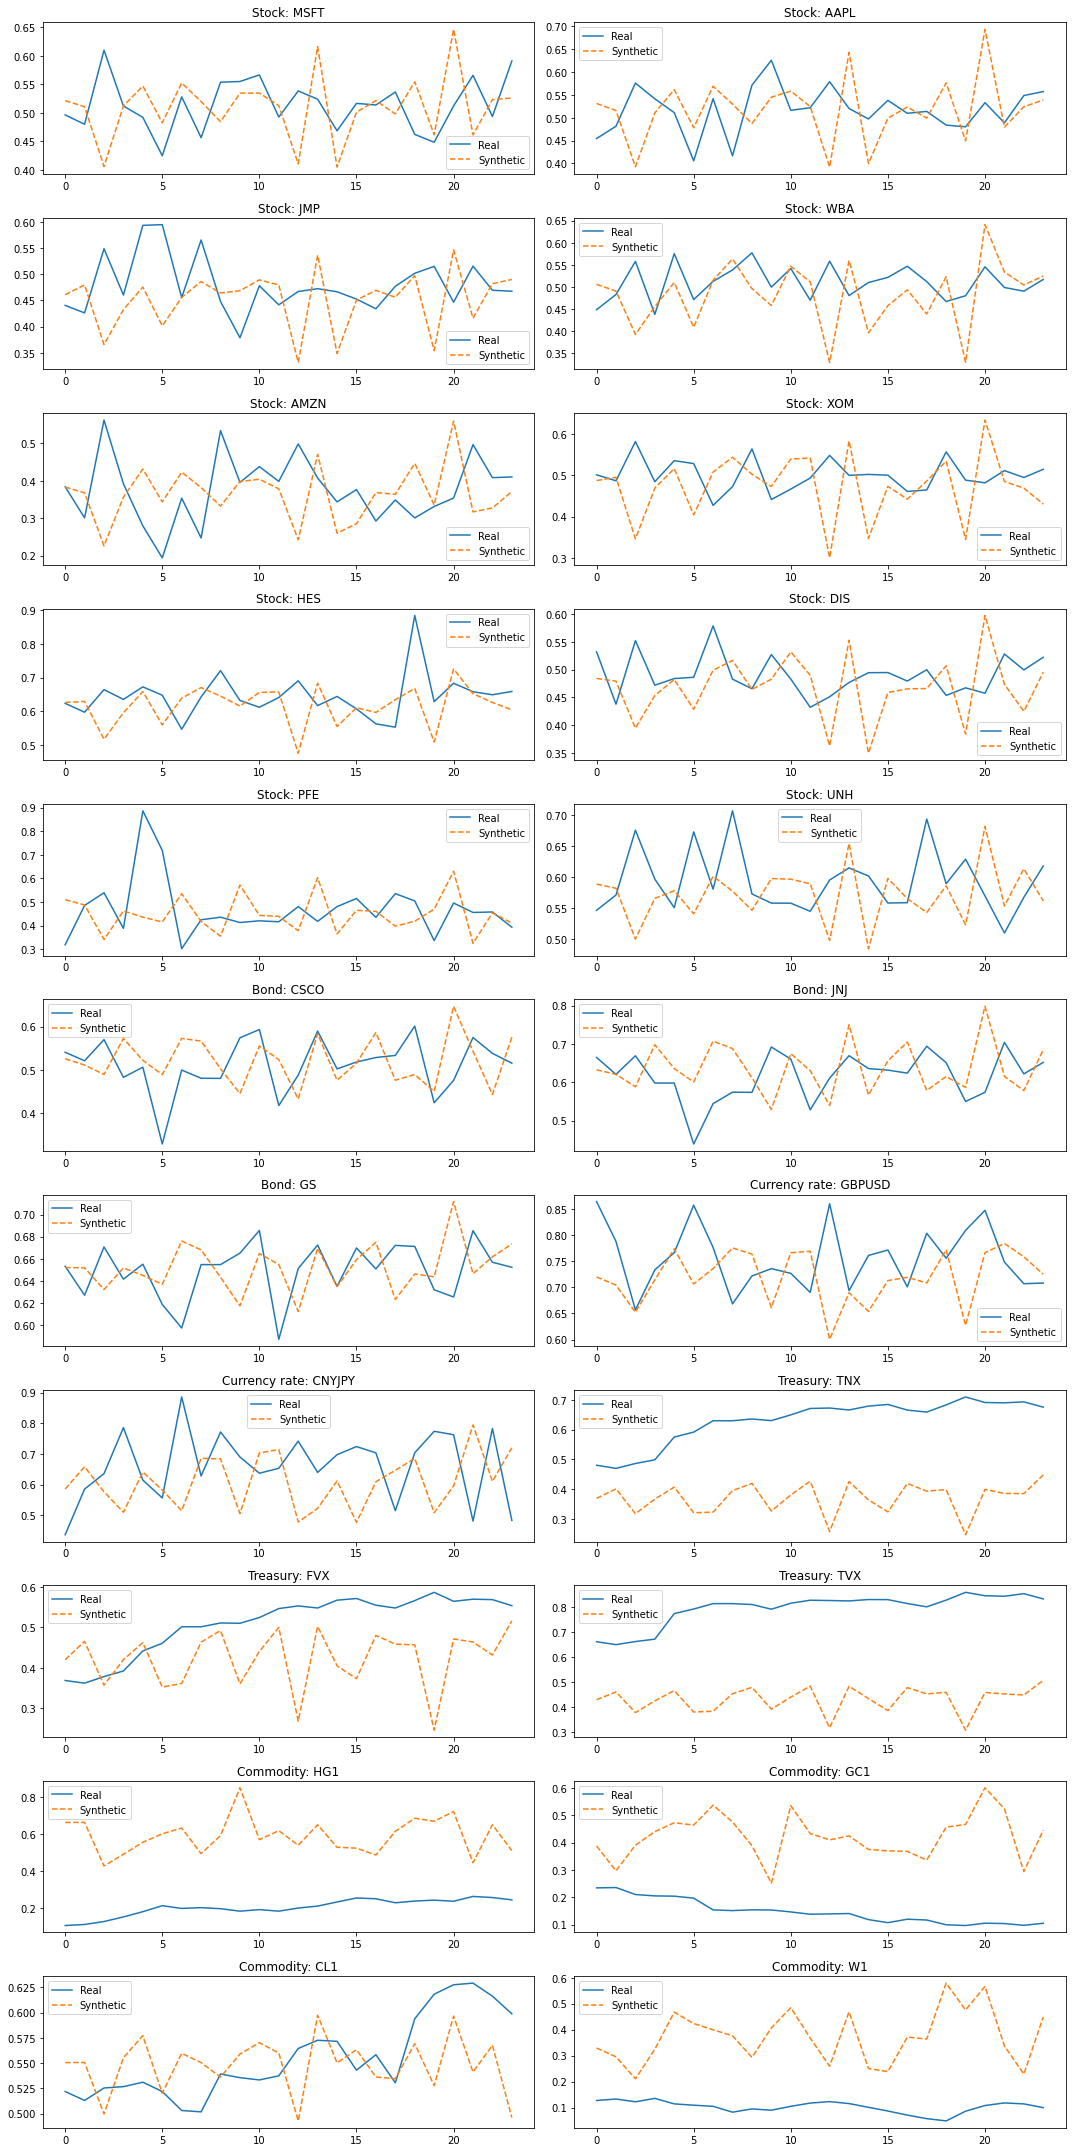

In [28]:
#Reshaping the data
cols = ['Stock: MSFT','Stock: AAPL','Stock: JMP','Stock: WBA','Stock: AMZN','Stock: XOM','Stock: HES','Stock: DIS',
        'Stock: PFE','Stock: UNH','Bond: CSCO','Bond: JNJ','Bond: GS','Currency rate: GBPUSD','Currency rate: CNYJPY',
        'Treasury: TNX','Treasury: FVX','Treasury: TVX','Commodity: HG1','Commodity: GC1','Commodity: CL1','Commodity: W1']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(15, 30))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()
fig.savefig('six_stocks_ts.jpg',dpi=400)

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

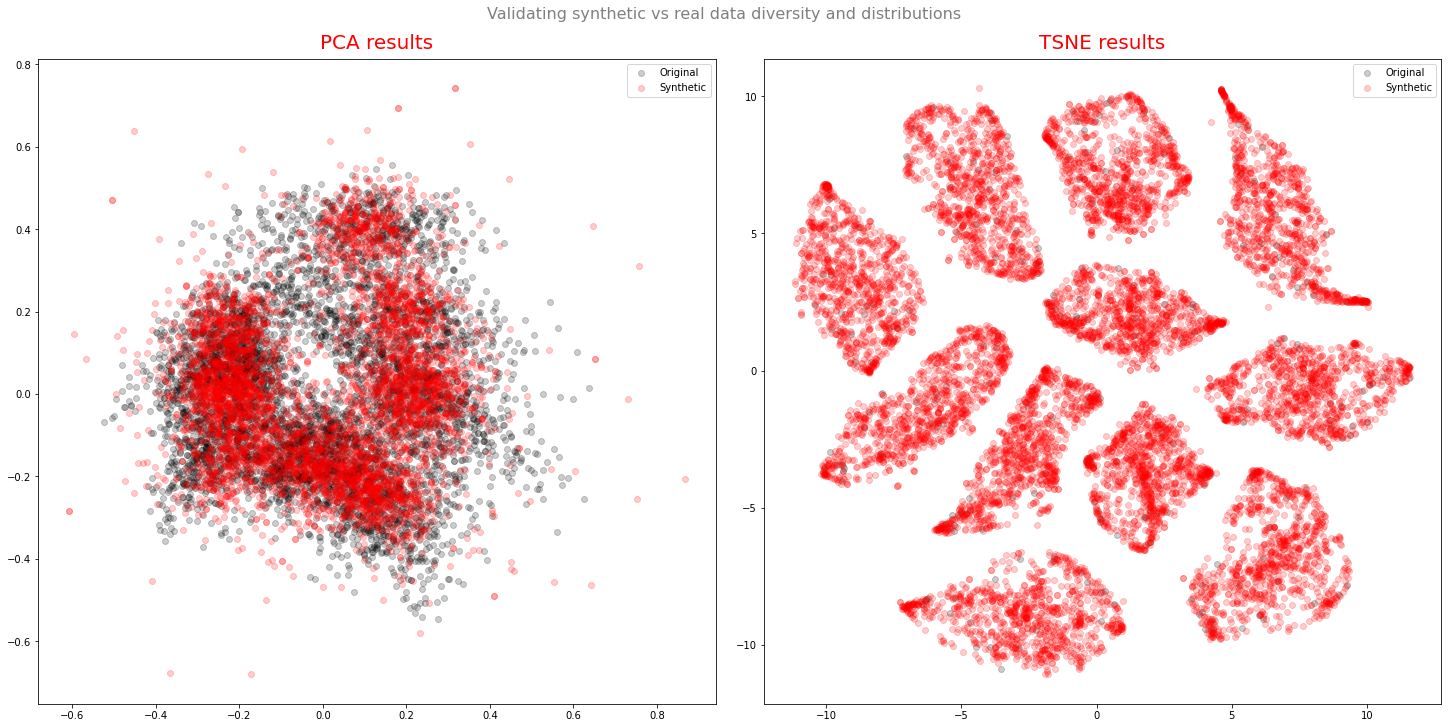

In [18]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')
fig.savefig('vali.jpg',dpi=400)

#### Train synthetic test real (TSTR)

In [20]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [21]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (1037, 23, 22)
Real X train: (1037, 23, 22)
Synthetic y train: (1037, 22)
Real y train: (1037, 22)
Real X test: (346, 23, 22)
Real y test: (346, 22)


In [22]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200


ValueError: in user code:

    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\losses.py:1231 mean_absolute_error
        return K.mean(math_ops.abs(y_pred - y_true), axis=-1)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:1180 binary_op_wrapper
        raise e
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\math_ops.py:561 subtract
        return gen_math_ops.sub(x, y, name)
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10315 sub
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:3528 _create_op_internal
        ret = Operation(
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\oxb88\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 6 and 22 for '{{node MAE/sub}} = Sub[T=DT_FLOAT](sequential/OUT/Sigmoid, IteratorGetNext:1)' with input shapes: [?,6], [?,22].


In [18]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
30/30 [==============================] - 2s 15ms/step - loss: 0.0678 - val_loss: 0.0378
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0424 - val_loss: 0.0353
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0418 - val_loss: 0.0352
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0422 - val_loss: 0.0351
Epoch 5/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0423 - val_loss: 0.0351


In [19]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,-0.009282,0.035048,0.001291
Synthetic,-0.005944,0.035148,0.001289
